In [1]:
from IPython.core.display import HTML
import urllib2

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Effective Data Science Pipelines

* David Marx @DigThatData
* http://dmarx.github.io

Demo available at: https://github.com/dmarx/make_for_datascience

# Motivation

## How We Hurt Ourselves

* Unnecessary code reproduction
* Circular dependencies
* Unreproducible results
* Non-portable code
* Lack of documentation
* No standard project layout

## Use Cases/Pain Points

* Evaluating competing models
* Modify models/data, only need to refresh downstream dependencies
* Navigating dependencies
* Reducing "spaghetti" projects
* Defining clear entry-point into the code base
* On-boarding overhead
* Data provenance overhead (i.e. debugging)
* Reproducibility/portability

## Principles of a Solution

* Low adoption LOE
* Minimal external dependencies
* OS agnostic
* Tool agnostic
* Encourage project standardization
* Compatible with version control
* Self-documenting
* Different functional elements should be isolated from each other


# Pipeline Management

## What do pipelines do for us?

* Ensure process with multiple steps across several files is run in correct sequence
* Help us create objects that don't exist
* Help us rebuild objects after dependencies have been modified
* Defines a clear entry-point into the project

## What else *can* pipelines do for us?

* Identify/eliminate circular dependencies
* Constrain build to only objects that need to be created/refreshed

## Why should I use a pipeline manager?

You're going to author a pipeline anyway (sometimes called a "master script", e.g. `read_data_and_fit_models.r`). May as well do it right.

## Popular tools

* Gnu Make
* Spotify Luigi
* Apache Airflow
* Apache Ant
* Waf (python)

... https://en.wikipedia.org/wiki/List_of_build_automation_software

# A Brief Intro To Gnu Make

https://www.gnu.org/software/make/manual/html_node/index.html#SEC_Contents

## Why Make?

* Pre-installed on \*NIX
  * To use on windows requires cygwin (or some other Unix emulator) or a windows port like gnuwin32
* Easy to use (if you KISS)
* Automatically identifies modified dependencies
* Long history of use, lots of tutorials/examples/documentation

## The Makefile

* Rules
* Special variables
* Functions

# Make Rules

## Simple Rule

```
target: dependency
    recipe
```

NB: Spaces != Tabs: recipes need to be indented with tabs

## Pattern Rule

```
%.rdata: %.csv
    Rscript read_data.r
```

## Pattern Rule: Semantic Folder Structure

```
models/%.rdata: data/%.rdata
    Rscript fit_model.r 
```

# Make Variables

## Automatic Variables

* \$@: The first target

```
models/%.rdata: train_and_save_model.r data/basetable.rdata code/models/%.r 
    Rscript train_and_save_model.r $@
```

* \$<: The first pre-requisite

```
models/%.rdata: train_and_save_model.r data/basetable.rdata code/models/%.r 
    Rscript $< $@
```

## Declared Variables

### varName = value

* Recursive (i.e. lazy) expansion
* Values are defined verbatim via text substitution
* If assigning from another variable, that variable is not evaluated: the text invoking it is what gets assigned

Running the following Makefile

```
foo = $(bar)
bar = $(ugh)
ugh = Huh?

all:
    echo $(foo)
```
will echo "Huh?": 

`$(foo)` expands to "\$(bar)" which expands to "\$(ugh)" which finally expands to "Huh?".

## Declared Variables (pt.2)

### varName := value

  * Simple expansion 
  * About as close to "immediate" as we can get
  * Applies value at time of assignment (if you're careful)
  * Really, nothing is for sure until the Makefile is fully compiled

```
x := foo
y := $(x) bar
x := baz
```

is equivalent to

```
y := foo bar
x := baz
```

# HERE THERE BE DRAGONS

```
x := foo

test::
	echo FIRST $(x)
    
x := bar

test::
	echo SECOND $(x)
```

will not echo:

```
FIRST foo
SECOND bar
```

but rather:

```
FIRST bar
SECOND bar
```

> ## 3.7 How make Reads a Makefile

> GNU make does its work in **two distinct phases**. During the first phase it reads all the makefiles, included makefiles, etc. and internalizes all the variables and their values, implicit and explicit rules, and constructs a dependency graph of all the targets and their prerequisites. During the second phase, make uses these internal structures to determine what targets will need to be rebuilt and to invoke the rules necessary to do so.

> It’s important to understand this two-phase approach because it has a direct impact on how variable and function expansion happens; **this is often a source of some confusion** when writing makefiles.

-- https://www.gnu.org/software/make/manual/html_node/Reading-Makefiles.html#Reading-Makefiles

## Functions

There are a ton of different functions. Here are a few that I find especially useful

* $(**patsubst** pattern,replacement,text)
  * Pattern substitution
  * `$(patsubst foo/%.bar,%.baz,foo/fname.bar)` :  -> `fname.baz`
  
* $(**wildcard** pattern)
  * Return a space-seperated list of filenames matching pattern
  * `$(wildcard data/*.csv)` -> `raw.csv results.csv errors.csv`
  
* $(**dir** names…)
  * Directory extraction
  * `$(dir path/to/file.txt foo/bar.csv)` : -> 'path/to/ foo/`
  
* $(**notdir** names…)
  * Non-directory part of file name
  * `$(dir path/to/file.txt foo/bar.csv)` : -> 'file.txt bar.csv'
  
* $(**shell** statement)
  * Let's you run shell commands anywhere in the makefile (i.e. outside of recipes, where you already can)
  
* $(**eval** statement)
  * Evaluate makefile syntax
  * Expanded twice: first by eval function, *then again* during the second phase when the makefile is actually "run"
  * Allows us to define and invoke Make variables (actually) immediately inside recipes
  

## The \$(eval ...) Trick

* Use a prefix to define a new variable name
* Use the `$(eval ...)` function to evaluate the prefix and variable value, and assign that into our "common" variable
  * This will probably seem redundant, but you'll see how it's useful in a bit


```
x := who

v1 = first/path
$(v1)_x := foo

test::
    $(eval x := $($(v1)_x))
    echo FIRST $(x)
    
x := cares

v2 = second/path
$(v2)_x := bar

test::
    $(eval x := $($(v2)_x))
    echo SECOND $(x)
```


will echo:

```
FIRST foo
SECOND bar
```
  
rather than:
    
```
FIRST cares
SECOND cares
```


# Data Science Pipelines with Make

## Pipeline entities

* raw data "getters"
* raw data
* features
* analytic base tables
* modeling tasks
* models
* model evaluation strategies

## A minimal pipeline

* Don't need to be fancy: specify targets and dependencies explicitly

```
data/iris.rdata:
     Rscript -e 'data(iris); save(iris, file=\"data/iris.rdata\")'

data/train.rdata data/test.rdata: data/iris.rdata src/train_test_split.r
     Rscript src/train_test_split.r

models/logreg.rdata: data/train.rdata src/logreg.r
     Rscript src/logreg.r
     
reports/confusion_matrix.txt: models/logreg.rdata data/test.rdata
     Rscript src/eval_model.r models/logreg.rdata
```

In [2]:
makefile = """
data/iris.rdata:
     Rscript -e 'data(iris); save(iris, file=\"data/iris.rdata\")'

data/train.rdata data/test.rdata: data/iris.rdata src/train_test_split.r
     Rscript src/train_test_split.r

models/logreg.rdata: data/train.rdata src/logreg.r
     Rscript src/logreg.r
     
reports/confusion_matrix.txt: models/logreg.rdata data/test.rdata
     Rscript src/eval_model.r models/logreg.rdata
"""

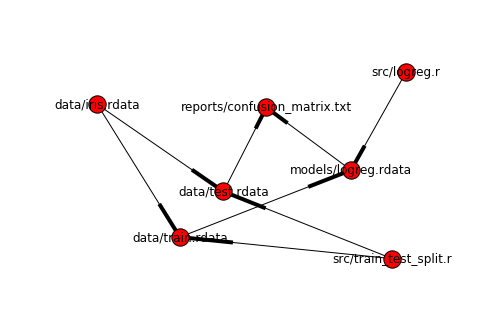

In [3]:
lines = makefile.split('\n')
rules = [line for line in lines if ':' in line]

g = nx.DiGraph()
for rule in rules:
    tgts, deps = rule.split(':')
    for tgt in tgts.split():
        for dep in deps.split():
            g.add_edge(dep, tgt)

np.random.seed(10)
nx.draw(g, with_labels='true')

## Pros:

* Make will automatically identify what needs to be rebuilt and only run the pipeline from there
* Dependencies are explicit

## Cons

* As the project grows, so will the make file
  * For every model candidate we want to try, we need to add two rules to the make file

## Let Make do the work
* Generalize pipeline steps with pattern rules and scripts that take arguments
* Invoke Make to infer files pipeline needs to create
    * Standardized naming conventions 
    * Semantic folder structure
    * `$(patsubst ... $(wildcard ...))`

```
############################
## Project specific rules ##
############################

data/iris.rdata:
     Rscript -e 'data(iris); base_table <- iris; save(base_table, file=\"data/base_table.rdata\")'
```

```

###################
## General rules ##
###################

r_model_specs := $(wildcard $src/models/*.r)
r_mod_names := $(notdir $(r_model_specs))
r_reports := $(patsubst %,reports/%_confusion_matrix.txt, $(r_mod_names))

.PHONY:all
all: $(r_reports)
```

``` 

data/train.rdata data/test.rdata: data/base_table.rdata src/train_test_split.r
     Rscript src/train_test_split.r $<

models/%.rdata: src/models/%.r train_and_save_model.r data/train.rdata 
     Rscript build_model.r $<
     
reports/%_confusion_matrix.txt: models/%.rdata data/test.rdata
     Rscript src/eval_model.r $<     
```

## What did we just gain?

* For every script matching the file name `src/model/modelName.r`, Make will automatically: 
  * Save a trained model object to `models/modelName.rdata`
  * Save a confusion matrix to `reports/modelName.r_confusion_matrix.txt`

## Multiple modeling tasks

* Modeling tasks identifiable by a unique base table
* Project identifiable by data/features common to one or more base tables
* Recursive Make vs. Non-recursive make
  * Performance gains
  * Project standardization

* Top level Makefile defines common variables and traverses project
 
```
## proectName/Makefile ##

train_data=data/processed/train.rdata
test_data=data/processed/test.rdata
abt=data/processed/analyticBaseTable.rdata
abt_script=src/data/build_base_table.r
R_INTERPRETER=Rscript

MODULES=$(patsubst ./%/Makefile,%, $(filter ./%/Makefile,  $(shell find . -type f -name 'Makefile')))
include $(addsuffix /Makefile,$(MODULES))

.PHONY all
all::
```


* Makefile "header" identifies current location in a variable
* Default ABT rule can be overriden

```
## projectName/_header.mak ##

_MAKEFILES := $(filter-out _header.mak _footer.mak,$(MAKEFILE_LIST))
_MODULE := $(patsubst %/,%,$(dir $(word $(words $(_MAKEFILES)),$(_MAKEFILES))))

$(_MODULE)/$(abt): $(_MODULE)/$(abt_script) common/data/processed/features.rdata
	$(R_INTERPRETER) $<
```

* Task-specific Makefile just needs to be a skeleton 
* Can be used to override defaults

```
## projectName/taskName/Makefile ##

include _header.mak

$(_MODULE)/$(abt): $(_MODULE)/$(abt_script) common/data/processed/other_features.rdata
	$(R_INTERPRETER) $<

include _footer.mak
```

* Makefile "footer" does most of the work
* Task directory resolved into targets and recipes

```
## projectName/_footer.mak

r_model_specs := $(wildcard $(_MODULE)/src/models/*.r)
r_mod_names := $(notdir $(r_model_specs))
r_test_acc := $(patsubst %,reports/%_confusion_matrix.txt, $(r_mod_names))

TGTS += $(abt) $(train_data) $(test_data) 
TGTS += $(patsubst %,models/%data, $(r_mod_names))
TGTS += $(r_test_acc)

$(_MODULE)/reports/%.r_confusion_matrix.txt: $(_MODULE)/models/%.rdata $(_MODULE)/$(test_data) common/src/eval/eval_model.r
	$(R_INTERPRETER) common/src/eval/eval_model.r $@    

$(_MODULE)/models/%.rdata: $(_MODULE)/src/models/%.r common/src/utils/train_and_save_model.r $(_MODULE)/$(train_data)
	$(R_INTERPRETER) common/src/utils/train_and_save_model.r $@
    
$(_MODULE)/$(train_data) $(_MODULE)/$(test_data): $(_MODULE)/$(abt) common/src/data/train_test_split.r
	$(R_INTERPRETER) common/src/data/train_test_split.r $<

$(_MODULE)_TGTS := $(addprefix $($(_MODULE)_OUTPUT)/,$(TGTS))

$(_MODULE): $($(_MODULE)_TGTS)

all:: $(_MODULE)
```

# The Demo

https://github.com/dmarx/make_for_datascience

## Using the demo

* Common data pre-processing steps need to be specified in `projectName/common/Makefile`
* To create a new modeling task:
  * Create a new folder under the project directory
  * Create a skeleton Makefile importing `_header.mak` and `_footer.mak`
  * Define model specifications in `projectName/taskName/src/models/modelName.r`
      * "Model specification" = `train_model()` and `predict_model()`
      
## Features

* Data profiling of all ABTs, profiles stored in DB with date and current commit
* Each ABT split into a training and holdout set
* All models evaluated by a common statistic. Porject-wide default can be overriden for a task-specific statistic
* Evaluation statistic subjected to bootstrapping and target shuffling for each model
* Model objects saved using full training data, old model objects optionally archived
* Confusion matrix against holdout data for each model
* All evaluation results persisted in database, logging task, model, date, and HEAD commit